## Energy of different consensus algorithms

### SHA-256 Proof-of-Work

In [69]:
sha_256 = mining_data[mining_data['algorithm'] == "SHA-256"].copy()
sha_256

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,position
Name,,,,,,,,,
bitcoin,1.582063e+11,8669.95,36604114509,18247675,BTC,SHA-256,1.554675e+13,599.0,0
bitcoincash,5.865094e+09,320.35,4251315222,18308363,BCH,SHA-256,5.728909e+11,600.0,3
bitcoinsv,4.250278e+09,232.18,2250321444,18305602,BSV,SHA-256,4.315897e+11,578.0,5


In [71]:
# All correct! 
sha_256['total_hash'] = sha_256['difficulty']*2**48/(65535) # or 2^32 
sha_256['nethash'] = sha_256['total_hash']/sha_256['block_time']
sha_256

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,position,total_hash,nethash
Name,,,,,,,,,,,
bitcoin,1.582063e+11,8669.95,36604114509,18247675,BTC,SHA-256,1.554675e+13,599.0,0,6.677378e+22,1.114754e+20
bitcoincash,5.865094e+09,320.35,4251315222,18308363,BCH,SHA-256,5.728909e+11,600.0,3,2.460585e+21,4.100975e+18
bitcoinsv,4.250278e+09,232.18,2250321444,18305602,BSV,SHA-256,4.315897e+11,578.0,5,1.853692e+21,3.207080e+18


### Equihash

In [76]:
equihash = mining_data[mining_data['algorithm'] == "Equihash"].copy()
equihash['(n,k)'] = [(200,9),(144,5),(0,0),(200,9)]
equihash

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,position,"(n,k)"
Name,,,,,,,,,,
zcash,460911098.0,50.030000,311995941,9212506,ZEC,Equihash,6.030782e+07,75.0,25,"(200, 9)"
bitcoingold,170070863.0,9.710000,39606584,17513924,BTG,Equihash,1.765900e+05,600.0,38,"(144, 5)"
horizen,85591701.0,10.020000,1543230,8539588,ZEN,Equihash,1.404942e+07,150.0,63,"(0, 0)"
komodo,75922471.0,0.640276,2536293,118577670,KMD,Equihash,2.007803e+08,62.0,69,"(200, 9)"


In [129]:
equihash['alg_runs'] = 2**13*equihash['difficulty']/2 # Starting difficulty of Zcash, times the relative difficulty, divided by amount of solution
equihash['hashrate'] = equihash['alg_runs']/equihash['block_time']
equihash

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,position,"(n,k)",alg_runs,hashrate
Name,,,,,,,,,,,,
zcash,460911098.0,50.030000,311995941,9212506,ZEC,Equihash,6.030782e+07,75.0,25,"(200, 9)",2.470208e+11,3.293611e+09
bitcoingold,170070863.0,9.710000,39606584,17513924,BTG,Equihash,1.765900e+05,600.0,38,"(144, 5)",7.233126e+08,1.205521e+06
horizen,85591701.0,10.020000,1543230,8539588,ZEN,Equihash,1.404942e+07,150.0,63,"(0, 0)",5.754643e+10,3.836429e+08
komodo,75922471.0,0.640276,2536293,118577670,KMD,Equihash,2.007803e+08,62.0,69,"(200, 9)",8.223963e+11,1.326446e+10


### Scrypt

In [130]:
scrypt = mining_data[mining_data['algorithm'] == "Scrypt"].copy()
scrypt

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position,reward_per_sec
Name,,,,,,,,,,,,
litecoin,3.801726e+09,59.210000,4433870551,64202387,LTC,Scrypt,5.975834e+06,140.0,12.500000,75.559274,6,6.746364
dogecoin,2.820381e+08,0.002283,166256231,123544326274,DOGE,Scrypt,2.453764e+06,62.0,10000.000000,0.002604,32,0.420077
digibyte,7.191128e+07,0.005583,824878,12880917393,DGB,Scrypt,2.286140e+04,15.0,665.639774,0.005608,71,0.248842
verge,5.942903e+07,0.003670,691527,16193811143,XVG,Scrypt,5.664491e+03,30.0,730.000000,0.003680,81,0.089546


In [136]:
# TODO: all litecoin! 
scrypt.loc['litecoin','alg_runs'] = 2**32*scrypt.loc['litecoin','difficulty']/scrypt.loc['litecoin','block_time'] # https://litecoin.info/index.php/Difficulty
scrypt

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position,reward_per_sec,alg_runs
Name,,,,,,,,,,,,,
litecoin,3.801726e+09,59.210000,4433870551,64202387,LTC,Scrypt,5.975834e+06,140.0,12.500000,75.559274,6,6.746364,1.833287e+14
dogecoin,2.820381e+08,0.002283,166256231,123544326274,DOGE,Scrypt,2.453764e+06,62.0,10000.000000,0.002604,32,0.420077,NaN
digibyte,7.191128e+07,0.005583,824878,12880917393,DGB,Scrypt,2.286140e+04,15.0,665.639774,0.005608,71,0.248842,NaN
verge,5.942903e+07,0.003670,691527,16193811143,XVG,Scrypt,5.664491e+03,30.0,730.000000,0.003680,81,0.089546,NaN


### EtHash

In [131]:
ethash = mining_data[mining_data['algorithm'] == "EtHash"].copy()
ethash

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position,reward_per_sec
Name,,,,,,,,,,,,
ethereum,2.440093e+10,221.98,17556366958,109925923,ETH,EtHash,2.244509e+15,15.0,2.0,224.138591,1,29.885145
ethereumclassic,9.465897e+08,8.14,1614433225,116313299,ETC,EtHash,1.543936e+14,15.0,4.0,8.145615,17,2.172164


In [134]:
ethash['hashrate'] = ethash['difficulty']/ethash['block_time']
ethash

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position,reward_per_sec,hashrate
Name,,,,,,,,,,,,,
ethereum,2.440093e+10,221.98,17556366958,109925923,ETH,EtHash,2.244509e+15,15.0,2.0,224.138591,1,29.885145,1.496340e+14
ethereumclassic,9.465897e+08,8.14,1614433225,116313299,ETC,EtHash,1.543936e+14,15.0,4.0,8.145615,17,2.172164,1.029291e+13


+- same as other online clients

## Lower bound

In this approach, we look at the number of hashes the miners are actually computing, which we know by observing the difficulty of each block. If we then assume that all miners are using the most efficient hardware, we can derive a lower bound on electricity consumption.

As of writing, the most efficient hardware is the 'Antminer S9', which calculates 14TH/s
https://www.buybitcoinworldwide.com/mining/hardware/

In [41]:
max_hash_rate = 14*10**12 # Hashes per second
joules_per_hash = 0.1/(10**9) # Joules per hash
energy_cons = max_hash_rate*joules_per_hash # In Watt

In [46]:
def lower_bound(coin):
    """
    Return a lower bound on the amount of energy (in W) needed for a cryptocurrency using the SHA-256 algorithm
    """
    # Hashrate per second needed
    hashrate = coin['nethash']
    # Amount of ASIC's needed to generate this hashrate
    num_hardware = hashrate/max_hash_rate
    total_energy = num_hardware*energy_cons
    return total_energy

In [49]:
energy = lower_bound(sha_256.loc['Bitcoin'])

In [50]:
# Convert W to Wh
energy_Wh = energy*3600 

In [52]:
print(f"The Bitcoin cryptocurrency consumes, as a minimum {energy_Wh/10**12} TWh of energy")

The Bitcoin cryptocurrency consumes, as a minimum 40.13054301165688 TWh of energy


In [53]:
sha_256.apply(lambda x: lower_bound(x)*3600/10**12, axis=1)

Bitcoin           40.130543
BitcoinCashABC     1.472058
BitcoinSV          1.154531
DGB-SHA            0.008688
LitecoinCash       0.001109
Myriad-SHA         3.265881
Nicehash-SHA       0.145141
Peercoin           0.000997
dtype: float64

## Reward to energy estimation

In [122]:
mining_data['reward_per_sec'] = mining_data['block_reward']*mining_data['exchange_rate']/mining_data['block_time']
mining_data

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position,reward_per_sec
Name,,,,,,,,,,,,
bitcoin,1.582063e+11,8669.950000,36604114509,18247675,BTC,SHA-256,1.554675e+13,599.0,12.619200,9706.250000,0,204.482654
ethereum,2.440093e+10,221.980000,17556366958,109925923,ETH,EtHash,2.244509e+15,15.0,2.000000,224.138591,1,29.885145
bitcoincash,5.865094e+09,320.350000,4251315222,18308363,BCH,SHA-256,5.728909e+11,600.0,12.500000,322.173093,3,6.711939
bitcoinsv,4.250278e+09,232.180000,2250321444,18305602,BSV,SHA-256,4.315897e+11,578.0,12.500000,285.189037,5,6.167583
litecoin,3.801726e+09,59.210000,4433870551,64202387,LTC,Scrypt,5.975834e+06,140.0,12.500000,75.559274,6,6.746364
cardano,1.226269e+09,0.047297,102267054,25927070538,ADA,PoS,NaN,NaN,NaN,NaN,11,NaN
monero,1.159233e+09,66.370000,101835102,17466147,XMR,RandomX,1.576720e+11,120.0,2.150000,66.854550,13,1.197811
tron,1.123979e+09,0.016856,1570324125,66682072191,TRX,DPoS,NaN,NaN,NaN,NaN,14,NaN
ethereumclassic,9.465897e+08,8.140000,1614433225,116313299,ETC,EtHash,1.543936e+14,15.0,4.000000,8.145615,17,2.172164


In [124]:
sum_of_rewards = np.sum(mining_data['reward_per_sec'])
sum_of_rewards

267.38749988175215

In [125]:
average_price = 0.14 # $ per kWh

In [126]:
sum_of_rewards/average_price

1909.9107134410865

## Bitcoin Energy Consumption Index

In [22]:
BECI = pd.read_csv('data/BECI_TWh.csv')
BECI['Date'] = pd.to_datetime(BECI['Date'])

In [28]:
BECI = BECI.set_index('Date')

In [30]:
BECI_avg = BECI.groupby(pd.Grouper(freq='M')).mean()

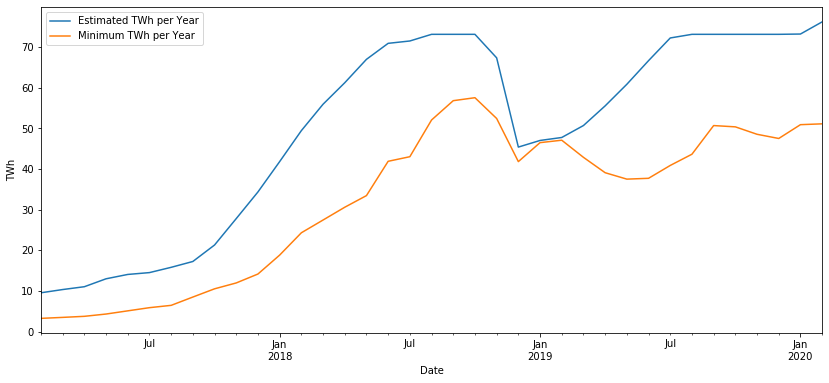

In [49]:
BECI_avg.plot(figsize=(14,6))
plt.ylabel('TWh')
plt.show()